In [71]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

from util.expectiles import tauspace
import imputers

from environments.igt import IowaGamblingTask, TwoStepIowaGamblingTask

In [2]:
env = IowaGamblingTask(split_rewards=True, scheme="R")
done = False
s = env.reset()
env.render()
while not done:
    s, r, done, _ = env.step(0)
    env.render()
env.close()

env = TwoStepIowaGamblingTask(split_rewards=True, scheme="R")
done = False
s = env.reset()
env.render()
while not done:
    s, r, done, _ = env.step(0)
    env.render()
env.close()

Iowa Gambling Task (Scheme R). 100 / 100 rounds complete.
Two-step Iowa Gambling Task (Scheme R). 100 / 100 rounds complete.


In [74]:
def train(env, agent, episodes=10000, render=True, log=False):
    if log: history = [agent.state()]
    for _ in tqdm.trange(episodes, unit="eps"):
        s = env.reset()
        done = False
        if render: env.render()
        while not done:
            a = agent.action(s)
            s_, r, done, _ = env.step(a)
            agent.update(s, a, r, s_, done)
            s = s_
            if render: env.render()
        if log: history.append(agent.state())
    if log: return np.array(history)

def plot_log(log, title="", ylabel=""):
    plt.figure(figsize=(14, 5))
    plt.title(title)
    for i in range(log.shape[-1]):
        plt.plot(log[:, 0, i], label=f"a={i}")
    plt.ylabel(ylabel)
    plt.xlabel("episode")
    plt.legend()
    plt.show()

def plot_states(log, title="", cm=plt.cm.viridis, ylim=[-6, 6], maxk=11):
    t, n, m, k = log.shape
    k_range = np.arange(k) if k <= maxk else np.linspace(0, k-1, maxk, dtype=int)
    print("showing streams", k_range)
    fig, axes = plt.subplots(m, n, figsize=(3*n, 3*m))
    for i in range(n):
        for j in range(m):
            axj = axes[j] if m > 1 else axes
            ax = axj[i] if n > 1 else axj
            ax.set_title(f"state {i}, action {j}")
            for l in k_range:
                ax.plot(log[:, i, j, l], color=cm(l/k))
        ax.set_xlabel("episodes")
    plt.tight_layout()
    plt.show()

In [180]:
class SARSA:
    def __init__(self, action_spaces, ε=0.05, α=0.001, γ=1.0, random_state=None):
        self.Q = {s: np.zeros(action_spaces[s].size) for s in range(len(action_spaces))}
        self.α = α
        self.γ = γ
        self.ε = ε
        self.rng = np.random.default_rng(seed=random_state)
        self.a_ = None
    def action(self, s):
        if self.a_ is not None:
            a = self.a_
            self.a_ = None
            return a
        else:
            exploring = (self.rng.random() < self.ε)
            if exploring:
                return np.random.choice(self.Q[s].size)
            else:
                return np.argmax(self.Q[s])
    def update(self, s, a, r, s_, terminal):
        if terminal:
            # no next state
            self.Q[s][a] += self.α * (r - self.Q[s][a])
        else:
            a_ = self.action(s_)
            self.a_ = a_
            self.Q[s][a] += self.α * (r + self.γ*self.Q[s_][a_] - self.Q[s][a])
    def state(self):
        return copy.deepcopy(list(self.Q.values()))

In [78]:
class ExpectileSARSA:
    def __init__(self, action_spaces, n_expectiles, imputer, ε=0.05, α=0.001, γ=1.0,
                 random_state=None, lrm=False):
        self.k = n_expectiles
        self.τ = tauspace(self.k)
        self.i = self.k // 2
        self.E = {s: np.zeros((action_spaces[s].size, self.k))
                  for s in range(len(action_spaces))}
        self.I = imputer
        self.α = α
        self.γ = γ
        self.ε = ε
        self.rng = np.random.default_rng(seed=random_state)
        self.a_ = None
        if lrm:
            self.lrm = 1/np.sqrt(self.τ * (1-self.τ))
        else:
            self.lrm = 2
    def action(self, s):
        if self.a_ is not None:
            a = self.a_
            self.a_ = None
            return a
        else:
            exploring = (self.rng.random() < self.ε)
            if exploring:
                return np.random.choice(self.E[s].shape[0])
            else:
                return np.argmax(self.E[s][:, self.i])
    def update(self, s, a, r, s_, terminal):
        # transform
        if terminal:
            X = r * np.ones_like(self.τ)
        else:
            a_ = self.action(s_)
            self.a_ = a_
            X = r + self.γ * self.I.fit(self.E[s_][a_], self.τ).sample(self.k)
        # step towards target expectiles according to ER loss
        rpe = X[:, np.newaxis] - self.E[s][a]
        scale = np.abs((rpe < 0) - self.τ)
        self.E[s][a] += self.α * self.lrm / self.k * np.sum(scale * rpe, axis=0)
    def state(self):
        return np.array(list(self.E.values()))

In [195]:
def experiment_igt(agent_class, episodes=200000, **kwargs):
    env = IowaGamblingTask(max_nrounds=1)
    agent = agent_class([env.action_space], **kwargs)
    log = train(env, agent, episodes=episodes, render=False, log=True)
    if len(log.shape) == 3:
        plot_log(log)
        plot_states(log[..., np.newaxis])
    else:
        plot_log(log[..., agent.i])
        plot_states(log)

/usr/local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


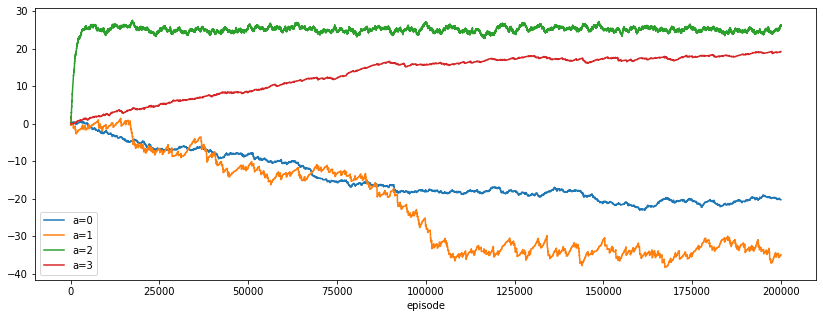

showing streams [0]


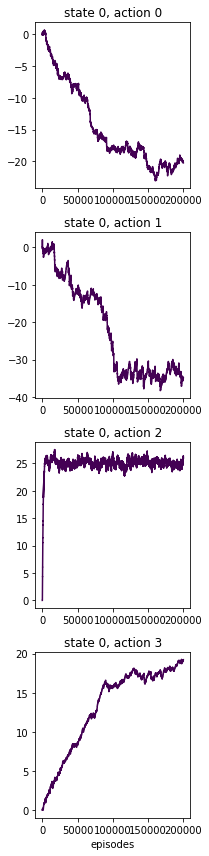

In [196]:
experiment_igt(SARSA)

/usr/local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


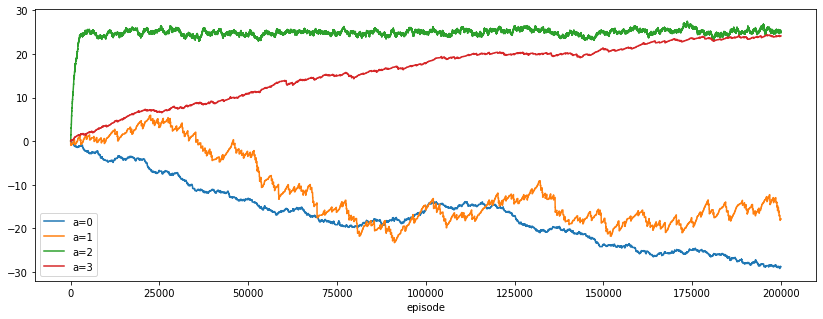

showing streams [ 0  1  2  3  4  5  6  7  8  9 10]


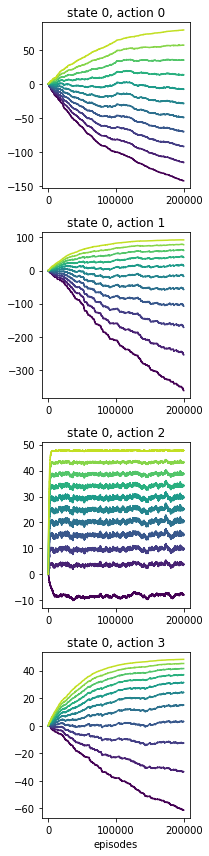

In [197]:
experiment_igt(ExpectileSARSA, n_expectiles=11, imputer=imputers.OptBasedImputer())
# note: imputer unused and expectiles unused in this one-step environment!!